# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import time
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from numpy import linalg as LA

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
display(df.sample(5, random_state=10000))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
231053,2016-03-15 19:47:01,2480,small,1997,manual,240,NaN,150000,12,petrol,audi,no,2016-03-15 00:00:00,0,90530,2016-04-02 23:15:58
65007,2016-03-07 07:55:49,5800,small,2005,manual,75,touran,150000,9,gasoline,volkswagen,no,2016-03-07 00:00:00,0,64289,2016-04-07 06:45:58
204414,2016-03-23 13:36:43,5900,sedan,2004,auto,150,c_klasse,150000,5,gasoline,mercedes_benz,no,2016-03-23 00:00:00,0,93471,2016-03-23 14:40:18
21261,2016-04-03 09:51:02,2250,wagon,1999,manual,165,a6,150000,12,petrol,audi,no,2016-04-03 00:00:00,0,47623,2016-04-05 08:49:25
279678,2016-03-19 15:56:14,9800,sedan,2010,manual,122,1er,60000,12,petrol,bmw,no,2016-03-19 00:00:00,0,59425,2016-03-23 02:49:28


In [4]:
df['VehicleType'] = df['VehicleType'].fillna(0)
df = df.query('VehicleType != 0')
df['Gearbox'] = df['Gearbox'].fillna(0)
df = df.query('Gearbox != 0')
df['Model'] = df['Model'].fillna(0)
df = df.query('Model != 0')
df['FuelType'] = df['FuelType'].fillna(0)
df = df.query('FuelType != 0')
df['NotRepaired'] = df['NotRepaired'].fillna('no')
df.info()
display(df.head())
df['NumberOfPictures'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 284126 entries, 2 to 354368
Data columns (total 16 columns):
DateCrawled          284126 non-null object
Price                284126 non-null int64
VehicleType          284126 non-null object
RegistrationYear     284126 non-null int64
Gearbox              284126 non-null object
Power                284126 non-null int64
Model                284126 non-null object
Kilometer            284126 non-null int64
RegistrationMonth    284126 non-null int64
FuelType             284126 non-null object
Brand                284126 non-null object
NotRepaired          284126 non-null object
DateCreated          284126 non-null object
NumberOfPictures     284126 non-null int64
PostalCode           284126 non-null int64
LastSeen             284126 non-null object
dtypes: int64(7), object(9)
memory usage: 36.9+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39


array([0])

In [5]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [6]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'PostalCode', 'NumberOfPictures', 'RegistrationMonth'], axis = 1)

                     Price  RegistrationYear     Power  Kilometer
Price             1.000000          0.548494  0.167917  -0.386360
RegistrationYear  0.548494          1.000000  0.063803  -0.325723
Power             0.167917          0.063803  1.000000   0.022887
Kilometer        -0.386360         -0.325723  0.022887   1.000000


,Price,RegistrationYear,Power,Kilometer
count,284121.000000,284121.00000,284121.000000,284121.000000
mean,4847.271638,2002.56786,117.726581,128261.902499
std,4637.060177,6.24385,169.108595,36739.686622
min,0.000000,1910.00000,0.000000,5000.000000
25%,1300.000000,1999.00000,75.000000,125000.000000
50%,3199.000000,2003.00000,109.000000,150000.000000
75%,6999.000000,2007.00000,147.000000,150000.000000
max,20000.000000,2018.00000,20000.000000,150000.000000


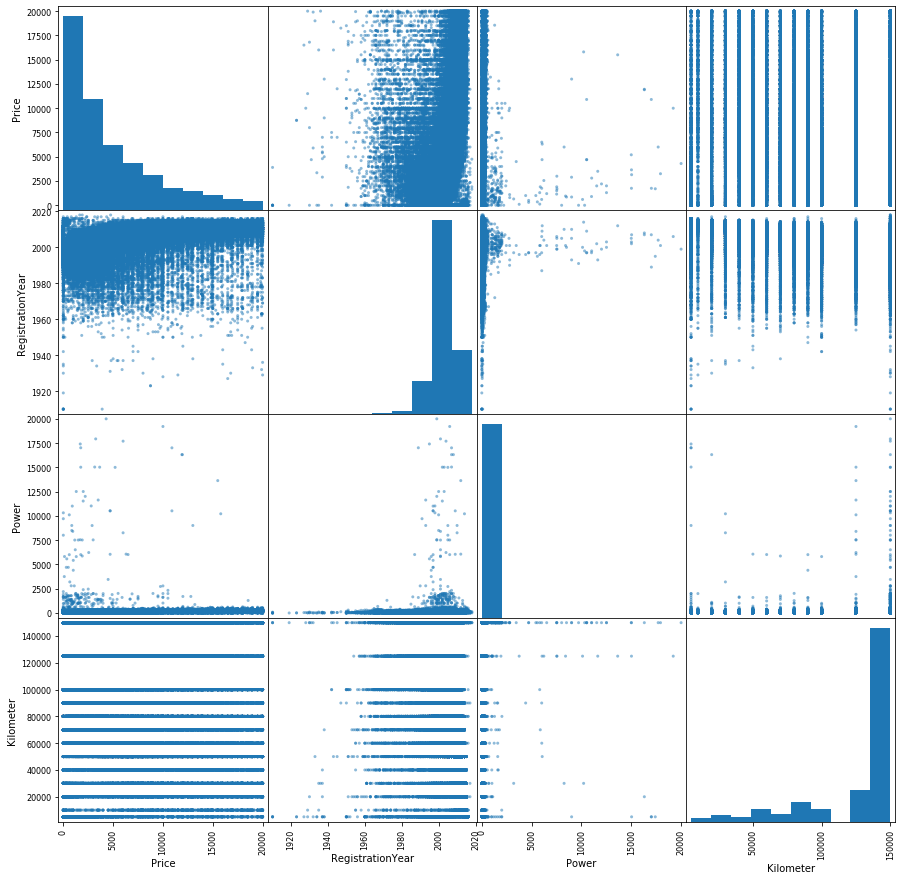

In [7]:
pd.plotting.scatter_matrix(df, figsize=(15, 15))
print(df.corr())
df.describe()
#t = time.time()
#print(time.time() - t)

В результате изучения данных обнаружены пропуски в колонках VehicleType - тип автомобильного кузова , Gearbox - тип коробки передач, Model - модель автомобиля, FuelType - тип топлива, NotRepaired - была машина в ремонте или нет. Первые четыре колонки являются важными показателями, влияющими сильно на цену автомобиля. Поэтому заменить их например средним значением нелогично и некорректно. Чтобы избавиться от негативных влияний я удаляю эти значения, в общем сумме данные сократятся на 20%. Это достаточно большая потеря, но все равно считаю, что данных для обучения останется достаточно. Вариант поставить значения "other" мне не нравится, потому что просто выделяем неизвестные значения в общий столбец, и они будут как-то неккоректно влиять. Для столбца NotRepaired предположил замену сделать на "нет", потому что это более вероятно, если бы был ремонт это было бы в базе. Все данные за 16 год, все в одном временном диапазоне.
Столбцы 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'PostalCode', 'NumberOfPictures', 'RegistrationMonth' были удалены как ненужные, они содержат лишнюю информацию, которая будет утежелять модель, а также искажать данные. Стобец NumberOfPictures содержит только нулевые значения.

## Обучение моделей

In [8]:
df['VehicleType'] = df['VehicleType'].astype('category')
df['Gearbox'] = df['Gearbox'].astype('category')
df['Model'] = df['Model'].astype('category')
df['FuelType'] = df['FuelType'].astype('category')
df['Brand'] = df['Brand'].astype('category')
df['NotRepaired'] = df['NotRepaired'].astype('category')

In [9]:
features = df.drop('Price', axis=1)
target = df['Price']

In [10]:
display(df.head())
df.info()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 284121 entries, 2 to 354368
Data columns (total 10 columns):
Price               284121 non-null int64
VehicleType         284121 non-null category
RegistrationYear    284121 non-null int64
Gearbox             284121 non-null category
Power               284121 non-null int64
Model               284121 non-null category
Kilometer           284121 non-null int64
FuelType            284121 non-null category
Brand               284121 non-null category
NotRepaired         284121 non-null category
dtypes: category(6), int64(4)
memory usage: 12.7 MB


In [11]:
target = df['Price']
features = df.drop('Price', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)

categorial_columns = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']

model = CatBoostRegressor(loss_function="RMSE", iterations=250, random_seed=12345, verbose=50)# < напишите код здесь >

In [12]:
start_time = time.time()
model.fit(features_train, target_train, cat_features=categorial_columns)
end_time = time.time() - start_time
start_time1 = time.time()
probabilities_valid = model.predict(features_valid)
end_time1 = time.time() - start_time1

0:	learn: 4542.8845191	total: 743ms	remaining: 3m 5s
50:	learn: 2410.8138685	total: 31.6s	remaining: 2m 3s
100:	learn: 2024.3112788	total: 1m	remaining: 1m 29s
150:	learn: 1921.8912747	total: 1m 30s	remaining: 59.1s
200:	learn: 1877.2684021	total: 2m	remaining: 29.3s
249:	learn: 1845.0767602	total: 2m 29s	remaining: 0us


In [13]:
print('Время обучения, сек:', end_time)
print('Время предсказания, сек:', end_time1)

Время обучения, сек: 151.50929021835327
Время предсказания, сек: 0.1662435531616211


In [14]:
booster = lgb.LGBMRegressor(objective="regression_l2", n_estimators=10)
start_time3 = time.time()
booster.fit(features_train, target_train, eval_set=[(features_valid, target_valid),], eval_metric=["rmse"])
end_time3 = time.time() - start_time3

start_time4 = time.time()
probabiliti_valid = booster.predict(features_valid)
end_time4 = time.time() - start_time4
print('Время обучения, сек:', end_time3)
print('Время предсказания, сек:', end_time4)

[1]	valid_0's rmse: 4290.8	valid_0's l2: 1.8411e+07
[2]	valid_0's rmse: 3988.03	valid_0's l2: 1.59044e+07
[3]	valid_0's rmse: 3721.83	valid_0's l2: 1.3852e+07
[4]	valid_0's rmse: 3485.39	valid_0's l2: 1.21479e+07
[5]	valid_0's rmse: 3279.98	valid_0's l2: 1.07583e+07
[6]	valid_0's rmse: 3099.07	valid_0's l2: 9.60421e+06
[7]	valid_0's rmse: 2939.25	valid_0's l2: 8.63917e+06
[8]	valid_0's rmse: 2800.46	valid_0's l2: 7.84259e+06
[9]	valid_0's rmse: 2676.13	valid_0's l2: 7.16168e+06
[10]	valid_0's rmse: 2567.26	valid_0's l2: 6.59084e+06
Время обучения, сек: 20.8784658908844
Время предсказания, сек: 0.197174072265625


Проведен расчет моделей методом градиентного бустинга CatBoost и LightGBM. Получены необходимые метрики и время расчета. Для того, чтобы работал метод LightGBM произведена замена типа "object" на тип "category". Метод CatBoost может работать и без этого, я проверил. Немного менял гиперпараметры в качестве обучения. В данном случае произвел разбивку исходного датафрейма на трейн и валид, тестовую решил не делать в связи с тем, что метрику rmse мы может получить в процессе работы бустингов.

In [17]:
target = df['Price']
features = df.drop('Price', axis=1)
#numeric1 = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

encoder = OrdinalEncoder()

#features_en = features1.drop(['RegistrationYear', 'Power', 'Kilometer'], axis=1)
features[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = encoder.fit_transform(features[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])

#features_ordinal['RegistrationYear'] = features1['RegistrationYear']
#features_ordinal['Power'] = features1['Power']
#features_ordinal['Kilometer'] = features1['Kilometer']


features_prom, features_test, target_prom, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_prom, target_prom, test_size=0.25, random_state=12345)

In [19]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284121 entries, 2 to 354368
Data columns (total 9 columns):
VehicleType         284121 non-null float64
RegistrationYear    284121 non-null int64
Gearbox             284121 non-null float64
Power               284121 non-null int64
Model               284121 non-null float64
Kilometer           284121 non-null int64
FuelType            284121 non-null float64
Brand               284121 non-null float64
NotRepaired         284121 non-null float64
dtypes: float64(6), int64(3)
memory usage: 21.7 MB


In [20]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [21]:
model_log = LinearRegression()# инициация модели линейной регрессии 
start_time5 = time.time()
model_log.fit(features_train, target_train) # обучение модели на тренировочной выборке
end_time5 = time.time() - start_time5

start_time6 = time.time()
predicted_log = model_log.predict(features_valid)
end_time6 = time.time() - start_time6

print("rmse мера модели линейной регрессии на валидационной выборке:", mean_squared_error(target_valid, predicted_log)**0.5)
print('Время обучения, сек:', end_time5)
print('Время предсказания, сек:', end_time6)

predicted_log_test = model_log.predict(features_test)
print("rmse мера модели линейной регрессии на тестовой выборке:", mean_squared_error(target_test, predicted_log_test)**0.5)

rmse мера модели линейной регрессии на валидационной выборке: 3345.6585378738732
Время обучения, сек: 0.048445701599121094
Время предсказания, сек: 0.004539966583251953
rmse мера модели линейной регрессии на тестовой выборке: 3393.34020384662


In [22]:
%%time
best_model_tree = None
best_result_tree = 0
for depth in range(1, 10):
	model_tree = DecisionTreeRegressor(random_state=10000, max_depth=depth) # обучение модели с заданной глубиной дерева
	model_tree.fit(features_train, target_train) # обучение модели
	predicted_tree = model_tree.predict(features_valid) # предсказания модели
	result_tree = mean_squared_error(target_valid, predicted_tree)**0.5 #  качество модели
	if result_tree > best_result_tree:
		best_model_tree = model_tree
		best_result_tree = result_tree
print("rmse модели решающего леса на валидационной выборке:", best_result_tree)

predicted_tree_test = model_tree.predict(features_test)
print("rmse мера модели решающего леса на тестовой выборке:", mean_squared_error(target_test, predicted_tree_test)**0.5)

rmse модели решающего леса на валидационной выборке: 3543.6702091721554
rmse мера модели решающего леса на тестовой выборке: 2108.5824541325214
CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.55 s


Произвольно выбраны две модели для сравнения. Проведена подготовка данных, скайлер (хоть он для линейной регрессии и не нужен). Для масштабирования выбран метод OrdinalEncoder не потому что он лучше подходит, а потому что он требует меньше времени на обработку, OHE слишком долгий.

## Анализ моделей

Метрика rmse получена и время расчета определено. Методы градиентного бустинга CatBoost 1845, LightGBM 2567. Получается что метод CatBoost лучше, время его работы 152,7 сек, а время работы LightGBM 61,6 сек. Казалось бы очевидно какое время больше или меньше, но правильнее нужно смотреть на количество итераций. Если я правильно понял, то в первом методе их 250, а во втором 10, соответственно CatBoost намного быстрее. Важно также отметить что во всех методах время на обучение значительно больше времени предсказания, что логично впринципе.
Далее я рассмотрел линейную регрессию и решающий лес, то что они считаются намного быстрее, это понятно и соответствует логике. 